**Deep Learning**

HW2 - Problem 3 -Latin Alphabet (80 pts)


Full Name: **Nima Kelidari**

Student Number: **98108124**


# **الف**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Deep_learning/HW2/Data/

/content/gdrive/MyDrive/Deep_learning/HW2/Data


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision

In [109]:
alphabets = pd.read_csv('./HW2_data/Q3_train.csv')



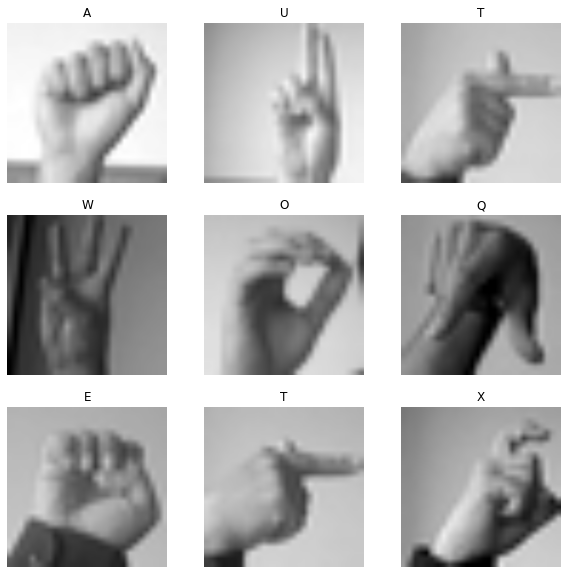

In [204]:
import cv2
show = alphabets.sample(n = 9)
labels_map = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O",
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
counter = 0
for i in range(9):
    uint_img = show.to_numpy()[i,1:].reshape((28,28)).astype('uint8')
    image = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
    img = cv2.resize(image, (512, 512),
               interpolation = cv2.INTER_LINEAR)
    label = show.to_numpy()[i,0]
    counter+=1
    figure.add_subplot(rows, cols, counter)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# **ب**

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(alphabets, test_size=0.25)

In [8]:
train = train.reset_index(drop=True)
train_labels = train['label']


In [9]:
train.drop('label',axis = 1,inplace = True)
train=(train-train.min())/(train.max()-train.min())

In [10]:
test = test.reset_index(drop=True)
test_labels = test['label']

In [11]:
test.drop('label',axis = 1,inplace = True)
test=(test-test.min())/(test.max()-test.min())

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self,features):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.features = features
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.features, 250),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(250, 100),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 25),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)


        return logits

In [34]:
model = NeuralNetwork(features=784).to(device)

In [35]:
from torch import optim

learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss().to(device)


For Adam optimizer:

In [ ]:
#optimizer = optim.Adam(model.parameters())

For SGD optimizer:

In [36]:
optimizer = optim.SGD(model.parameters(),lr = learning_rate,  momentum=0.9)

In [37]:
from torch.utils.data import Dataset, DataLoader

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [38]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [39]:
def train_model(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device).long()

        optimizer.zero_grad()
        y_pred= model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator) 

In [40]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device).long()

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

بعد از هربار ران شدن وزن ها در کلاس ذخیره مشوند. برای شروع کار از اول باید کلاس دوباره اجرا شود.

In [41]:
num_epochs = 100
batch_size = 256
train_data = Data(train.to_numpy(), train_labels.to_numpy())
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = Data(test.to_numpy(),test_labels.to_numpy())
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
from tqdm import tqdm

train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in tqdm(range(num_epochs)):
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, loss_fn, device)
    valid_loss, valid_acc = evaluate(model, test_dataloader, loss_fn, device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)

    if epoch % 10 ==0:
      print()
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("Training Complete")

  1%|          | 1/100 [00:00<00:52,  1.90it/s]


	Train Loss: 3.209 | Train Acc: 4.56%
	 Val. Loss: 3.194 |  Val. Acc: 4.77%


 11%|█         | 11/100 [00:05<00:46,  1.91it/s]


	Train Loss: 1.400 | Train Acc: 51.68%
	 Val. Loss: 1.208 |  Val. Acc: 57.87%


 21%|██        | 21/100 [00:11<00:41,  1.90it/s]


	Train Loss: 0.704 | Train Acc: 75.24%
	 Val. Loss: 0.518 |  Val. Acc: 83.26%


 31%|███       | 31/100 [00:16<00:36,  1.90it/s]


	Train Loss: 0.470 | Train Acc: 83.70%
	 Val. Loss: 0.254 |  Val. Acc: 93.00%


 41%|████      | 41/100 [00:21<00:32,  1.81it/s]


	Train Loss: 0.481 | Train Acc: 83.35%
	 Val. Loss: 0.250 |  Val. Acc: 91.93%


 51%|█████     | 51/100 [00:27<00:26,  1.82it/s]


	Train Loss: 0.530 | Train Acc: 81.50%
	 Val. Loss: 0.241 |  Val. Acc: 93.29%


 61%|██████    | 61/100 [00:32<00:21,  1.85it/s]


	Train Loss: 0.552 | Train Acc: 81.40%
	 Val. Loss: 0.229 |  Val. Acc: 92.73%


 71%|███████   | 71/100 [00:38<00:16,  1.78it/s]


	Train Loss: 0.497 | Train Acc: 82.98%
	 Val. Loss: 0.190 |  Val. Acc: 95.11%


 81%|████████  | 81/100 [00:44<00:09,  1.90it/s]


	Train Loss: 0.454 | Train Acc: 84.49%
	 Val. Loss: 0.170 |  Val. Acc: 95.71%


 91%|█████████ | 91/100 [00:49<00:05,  1.59it/s]


	Train Loss: 0.476 | Train Acc: 84.10%
	 Val. Loss: 0.163 |  Val. Acc: 94.98%


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]

Training Complete


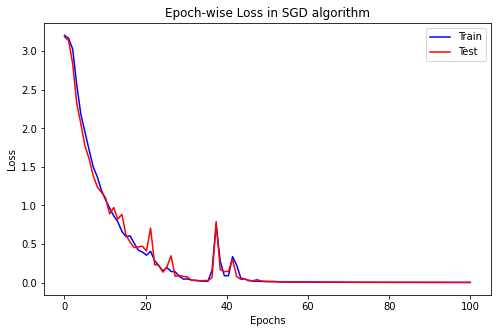

In [ ]:

step = np.linspace(0, num_epochs, num_epochs)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, train_loss_list,color='blue', label="Train")
plt.plot(step, valid_loss_list,color='red', label="Test")
plt.legend(loc="upper right")
plt.title("Epoch-wise Loss in SGD algorithm")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


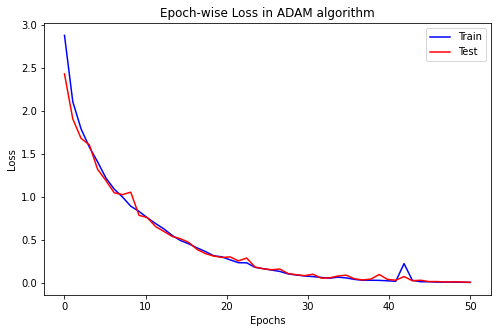

In [ ]:

step = np.linspace(0, num_epochs, num_epochs)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, train_loss_list,color='blue', label="Train")
plt.plot(step, valid_loss_list,color='red', label="Test")
plt.legend(loc="upper right")
plt.title("Epoch-wise Loss in ADAM algorithm")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# **ج**

Convergence in SGD was very faster and more effective. after it converge, it remains constant and plot will be like a line. but in adam we see some jumps after it conveges. i think SGD is a better algoritm for this specific example.

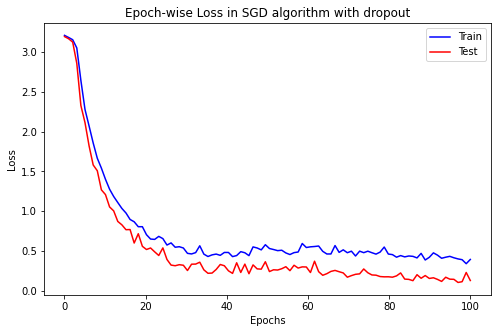

In [42]:

step = np.linspace(0, num_epochs, num_epochs)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, train_loss_list,color='blue', label="Train")
plt.plot(step, valid_loss_list,color='red', label="Test")
plt.legend(loc="upper right")
plt.title("Epoch-wise Loss in SGD algorithm with dropout")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


Dropout in this problem, didn't help to convergence.
rate of convergence deacreased and loss for training data extreamly increased.
but in validation data doesn't effect and it remains constant

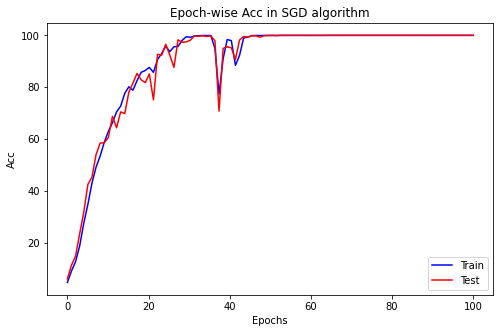

In [ ]:

step = np.linspace(0, num_epochs, num_epochs)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, train_acc_list,color='blue', label="Train")
plt.plot(step, valid_acc_list,color='red', label="Test")
plt.title("Epoch-wise Acc in SGD algorithm")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()


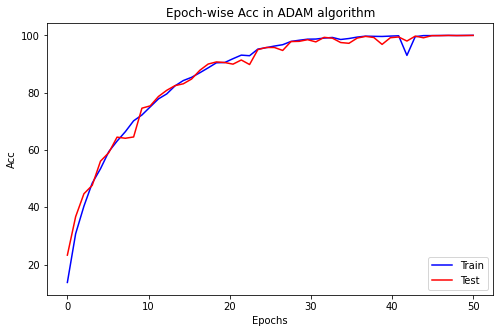

In [ ]:

step = np.linspace(0, num_epochs, num_epochs)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, train_acc_list,color='blue', label="Train")
plt.plot(step, valid_acc_list,color='red', label="Test")
plt.title("Epoch-wise Acc in ADAM algorithm")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()


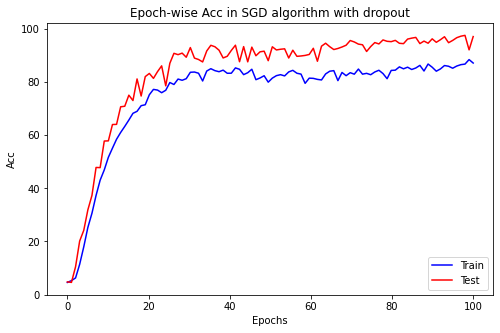

In [43]:

step = np.linspace(0, num_epochs, num_epochs)
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, train_acc_list,color='blue', label="Train")
plt.plot(step, valid_acc_list,color='red', label="Test")
plt.title("Epoch-wise Acc in SGD algorithm with dropout")
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.show()


In [44]:
import itertools
y_test = list(train_labels.copy().to_numpy())
percents = []
y_pred = []

with torch.no_grad():
      total=0
      correct = 0
      for X, y in test_dataloader:
          outputs = model(X.to(device)).to('cpu').numpy()
          predicted = np.argmax(outputs, axis=1)
          y = y.to('cpu').numpy()
          #print(y)
          #print(predicted)
          y_pred.append(predicted)
          y_test.append(y)
          total += len(y)
          correct += (predicted == y).sum().item()
print(correct)
print(f'Accuracy of the network on the {total} test instances: {100*correct / total} %')



6667
Accuracy of the network on the 6864 test instances: 97.12995337995338 %


# **د**

Best configuration:

Epochs : 50 steps

Optimization algorithm : SGD

learning rate : 0.01

momentum : 0.9

Batch size : 256

Dropout : NO

## **(ه) امتیازی**

In [51]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo1.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Run this block once

In [59]:
ims = []
labels = []
columns = []
for i in range(1,785):
  columns.append('pixel'+str(i))

Run this block for take picture and add it to data list

**Before run this, replace IMAGE_CLASS with you input class**

<IPython.core.display.Javascript object>

Saved to photo3.jpg


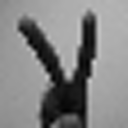

In [213]:
from google.colab.patches import cv2_imshow
from IPython.display import Image
try:
  filename = take_photo(filename='photo3.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  #display(Image(filename))

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

import cv2
image = cv2.imread(filename,0)
image = cv2.resize(image, (28, 28),interpolation = cv2.INTER_CUBIC)
cv2_imshow(cv2.resize(image, (128, 128),interpolation = cv2.INTER_CUBIC))

ims.append(list(np.array(image,dtype=np.float64).reshape(784)))
labels.append(21)

In [226]:
data = np.array(ims)
dataf = pd.DataFrame(data/255, columns=columns)
data = Data(dataf.to_numpy(), np.array(labels))
dataloader = DataLoader(dataset=data, batch_size=batch_size, shuffle=False)
dataf

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.603922,0.603922,0.615686,0.619608,0.631373,0.627451,0.639216,0.639216,0.643137,0.658824,...,0.596078,0.592157,0.584314,0.588235,0.560784,0.560784,0.549020,0.545098,0.537255,0.537255
1,0.603922,0.611765,0.615686,0.631373,0.619608,0.643137,0.643137,0.647059,0.650980,0.654902,...,0.619608,0.596078,0.607843,0.603922,0.580392,0.568627,0.584314,0.576471,0.580392,0.568627
2,0.490196,0.505882,0.525490,0.525490,0.533333,0.537255,0.556863,0.572549,0.568627,0.584314,...,0.545098,0.537255,0.517647,0.525490,0.521569,0.513725,0.517647,0.509804,0.505882,0.494118


In [225]:
ims.pop(2)
labels.pop(2)

21

In [228]:
for X, y in dataloader:
          X = X.to(device)
          outputs = model(X).cpu().detach().numpy()
          predict = outputs.argmax(1)
          print('Predicted labels : ',predict)
          print('True labels : ',y.numpy().astype('int'))




Predicted labels :  [ 2 14 21]
True labels :  [ 2 14 21]


برای نشان دادن تصاویر وارد شده از وبکم و برچسب درست و پیش بینی شده شان از بلاک زیر استفاده میکنیم.

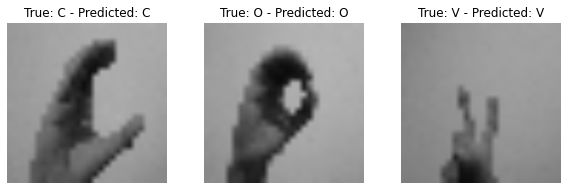

In [236]:
labels_map = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F",
    6: "G",
    7: "H",
    8: "I",
    9: "J",
    10: "K",
    11: "L",
    12: "M",
    13: "N",
    14: "O",
    15: "P",
    16: "Q",
    17: "R",
    18: "S",
    19: "T",
    20: "U",
    21: "V",
    22: "W",
    23: "X",
    24: "Y",
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
counter = 0
for i in range(3):
    uint_img = np.multiply(dataf.to_numpy()[i],255).reshape((28,28)).astype('uint8')
    image = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
    img = cv2.resize(image, (512, 512),
               interpolation = cv2.INTER_LINEAR)
    counter+=1
    figure.add_subplot(rows, cols, counter)
    plt.title('True: '+str(labels_map[labels[i]])+' - Predicted: '+str(labels_map[predict[i]]))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()